In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

raw = pd.read_csv("primary_by_precinct.csv", low_memory=False, dtype=str)
rows = raw.values.tolist()

def num(x):
    if x is None: return np.nan
    s = str(x).replace(",","").replace("%","").strip()
    if s == "": return np.nan
    try: return float(s)
    except: return np.nan

def is_empty_cell(v):
    if v is None: return True
    if isinstance(v, float) and pd.isna(v): return True
    if isinstance(v, str) and v.strip() == "": return True
    return False

def row_is_precinct(row, look_cols=6):
    """
    A precinct row is a STANDALONE 4-digit code.
    - The first non-empty cell within the first few cols must be 4 digits.
    - All other cells in that row must be empty.
    """
    first_nonempty_idx = None
    first_nonempty_val = None
    for j in range(min(look_cols, len(row))):
        v = row[j]
        if not is_empty_cell(v):
            first_nonempty_idx = j
            first_nonempty_val = v
            break
    if first_nonempty_val is None:
        return None

    # normalize (catch floats like 1004.0)
    if isinstance(first_nonempty_val, (int, float)) and not pd.isna(first_nonempty_val):
        s = str(int(float(first_nonempty_val)))
    else:
        s = str(first_nonempty_val).strip()

    if not re.fullmatch(r"\d{4}", s):
        return None

    # require rest of row to be empty (avoid catching table numbers, dates, etc.)
    for k in range(len(row)):
        if k == first_nonempty_idx: 
            continue
        if not is_empty_cell(row[k]):
            return None

    return s  # 4-digit precinct code

def first_label(row, n=3):
    for j in range(min(n, len(row))):
        v = row[j]
        if isinstance(v, str) and v.strip():
            return v.strip()
    return ""

def is_vote_for_row(row):
    return any(isinstance(v, str) and "VOTE FOR" in v.upper() for v in row)

def is_header_labels_row(row):
    labs = [str(x).strip().upper() if isinstance(x, str) else "" for x in row]
    return ("TOTAL" in labs) and any(x in labs for x in ["VOTE %","VOTE%","VOTE PCT","VOTE PCT.","PERCENT"])

def map_cols_from_header(row):
    labs = [str(x).strip().upper() if isinstance(x, str) else "" for x in row]
    m = {}
    for i, lab in enumerate(labs):
        if lab == "TOTAL": m["TOTAL"] = max(0, i-1)
        elif lab in ("VOTE %","VOTE%","VOTE PCT","VOTE PCT.","PERCENT"): m["PCT"] = max(0, i-1)
        elif ("ELECTION" in lab and "DAY" in lab): m["ED"] = max(0, i-1)
        elif ("ABSENT" in lab) or ("MAIL" in lab): m["ABS"] = max(0, i-1)
        elif ("EARLY" in lab and "VOT" in lab): m["EARLY"] = max(0, i-1)
    return m

TARGET = re.compile(r"\bDEM\w*\b.*\bDISTRICT\b.*\bCLERK\b", re.I)
STOP = {"", "TOTAL VOTES CAST", "OVERVOTES", "UNDERVOTES"}

records = []
precinct = None
i = 0
N = len(rows)

while i < N:
    r = rows[i]

    # precinct line (strict 4-digit, standalone)
    p = row_is_precinct(r, look_cols=6)
    if p:
        precinct = p
        i += 1
        continue

    # District Clerk contest
    label = first_label(r, n=3)
    if precinct and label and TARGET.search(label):
        # find header labels within next few lines; also require a 'Vote For' row in between
        header_row_idx = None
        vote_for_seen = False
        for look in range(1, 7):
            if i + look >= N: break
            if is_vote_for_row(rows[i + look]): vote_for_seen = True
            if is_header_labels_row(rows[i + look]):
                header_row_idx = i + look
                break
        if header_row_idx and vote_for_seen:
            colmap = map_cols_from_header(rows[header_row_idx])
            j = header_row_idx + 1

            # consume candidate rows
            while j < N:
                rr = rows[j]

                # if a new precinct line appears, stop this block
                npct = row_is_precinct(rr, look_cols=6)
                if npct:
                    precinct = npct
                    break

                name = rr[0] if isinstance(rr[0], str) else ""
                # end-of-block rows
                if (not name) or (name.strip().upper() in STOP):
                    t_idx = colmap.get("TOTAL")
                    if (t_idx is None) or (t_idx >= len(rr)) or (str(rr[t_idx]).strip() == ""):
                        break
                    j += 1
                    continue

                t_idx = colmap.get("TOTAL")
                if (t_idx is None) or (t_idx >= len(rr)) or (str(rr[t_idx]).strip() == ""):
                    break

                records.append({
                    "precinct": precinct,
                    "candidate": name.strip(),
                    "total_votes": num(rr[t_idx]),
                    "vote_pct": num(rr[colmap["PCT"]]) if "PCT" in colmap and colmap["PCT"] < len(rr) else np.nan,
                    "election_day": num(rr[colmap["ED"]]) if "ED" in colmap and colmap["ED"] < len(rr) else np.nan,
                    "absentee": num(rr[colmap["ABS"]]) if "ABS" in colmap and colmap["ABS"] < len(rr) else np.nan,
                    "early_voting": num(rr[colmap["EARLY"]]) if "EARLY" in colmap and colmap["EARLY"] < len(rr) else np.nan,
                })
                j += 1

            i = j
            continue

    i += 1

district_clerk = pd.DataFrame.from_records(records)
district_clerk["precinct"] = district_clerk["precinct"].astype(str).str.strip()

# keep exactly your 8 candidates
keep = {
    'Gloria A. Martinez',
    'DeEtt Dresch',
    'Christine "Chris" Castillo',
    'Erasmo RAZ Hernandez',
    'Jessica Zapata Bogardus',
    'Mary Angie Garcia',
    'Raul Davila',
    'Eduardo "Eddie" Pichardo'
}
district_clerk = district_clerk[district_clerk["candidate"].isin(keep)].copy()

# build by-precinct dataset
dc_long = (
    district_clerk.groupby(['precinct','candidate'], as_index=False)
                  .agg({'total_votes':'sum',
                        'vote_pct':'mean',
                        'election_day':'sum',
                        'absentee':'sum',
                        'early_voting':'sum'})
                  .sort_values(['precinct','candidate'])
)

# final safety: enforce 4-digit precincts only
dc_long = dc_long[dc_long['precinct'].str.fullmatch(r"\d{4}")].copy()

print("Precinct count:", dc_long['precinct'].nunique())
print(sorted(dc_long['precinct'].unique())[:20])  # sanity peek
dc_long.head(12)

Precinct count: 776
['1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008', '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016', '1017', '1018', '1019', '1020']


,precinct,candidate,total_votes,vote_pct,election_day,absentee,early_voting
0,1001,"Christine ""Chris"" Castillo",30.0,16.76,15.0,1.0,14.0
1,1001,DeEtt Dresch,3.0,1.68,1.0,0.0,2.0
2,1001,"Eduardo ""Eddie"" Pichardo",7.0,3.91,1.0,2.0,4.0
3,1001,Erasmo RAZ Hernandez,25.0,13.97,8.0,4.0,13.0
4,1001,Gloria A. Martinez,43.0,24.02,26.0,0.0,17.0
5,1001,Jessica Zapata Bogardus,21.0,11.73,11.0,0.0,10.0
6,1001,Mary Angie Garcia,44.0,24.58,20.0,4.0,20.0
7,1001,Raul Davila,6.0,3.35,2.0,1.0,3.0
8,1002,"Christine ""Chris"" Castillo",12.0,19.05,4.0,3.0,5.0
9,1002,DeEtt Dresch,2.0,3.17,1.0,0.0,1.0


In [2]:
dc_long.precinct.unique()

array(['1001', '1002', '1003', '1004', '1005', '1006', '1007', '1008',
       '1009', '1010', '1011', '1012', '1013', '1014', '1015', '1016',
       '1017', '1018', '1019', '1020', '1021', '1022', '1023', '1024',
       '1025', '1026', '1027', '1028', '1029', '1030', '1031', '1032',
       '1033', '1034', '1035', '1036', '1037', '1038', '1039', '1040',
       '1041', '1042', '1043', '1044', '1045', '1046', '1047', '1048',
       '1049', '1050', '1051', '1052', '1053', '1054', '1055', '1056',
       '1057', '1058', '1059', '1060', '1061', '1062', '1063', '1064',
       '1065', '1066', '1067', '1068', '1069', '1070', '1071', '1072',
       '1073', '1074', '1075', '1076', '1077', '1078', '1079', '1080',
       '1081', '1082', '1083', '1084', '1085', '1086', '1087', '1088',
       '1089', '1090', '1091', '1092', '1093', '1094', '1095', '1096',
       '1097', '1098', '1099', '1100', '1101', '1102', '1103', '1104',
       '1105', '1106', '1107', '1108', '1109', '1110', '1111', '1112',
      

In [3]:
# Dictionary of precinct → DataFrame
precinct_dfs = {p: g.copy() for p, g in dc_long.groupby("precinct")}

In [4]:
# Now you can access like:
precinct_dfs["1002"]   # gives DataFrame for precinct 1002

,precinct,candidate,total_votes,vote_pct,election_day,absentee,early_voting
8,1002,"Christine ""Chris"" Castillo",12.0,19.05,4.0,3.0,5.0
9,1002,DeEtt Dresch,2.0,3.17,1.0,0.0,1.0
10,1002,"Eduardo ""Eddie"" Pichardo",5.0,7.94,2.0,0.0,3.0
11,1002,Erasmo RAZ Hernandez,3.0,4.76,3.0,0.0,0.0
12,1002,Gloria A. Martinez,18.0,28.57,6.0,3.0,9.0
13,1002,Jessica Zapata Bogardus,4.0,6.35,1.0,2.0,1.0
14,1002,Mary Angie Garcia,13.0,20.63,5.0,3.0,5.0
15,1002,Raul Davila,6.0,9.52,2.0,0.0,4.0


In [5]:
# make sure precinct is clean string
dc_long["precinct"] = dc_long["precinct"].astype(str).str.strip()

for p in dc_long["precinct"].unique():
    subset = dc_long[dc_long["precinct"] == p].copy()
    subset.to_csv(f"precinct_{p}.csv", index=False)

print("Saved", len(dc_long["precinct"].unique()), "precinct files")

Saved 776 precinct files


Winner: Mary Angie Garcia with 44.0 votes
Runner-up: Gloria A. Martinez with 43.0 votes
Margin of victory: 1.0 votes


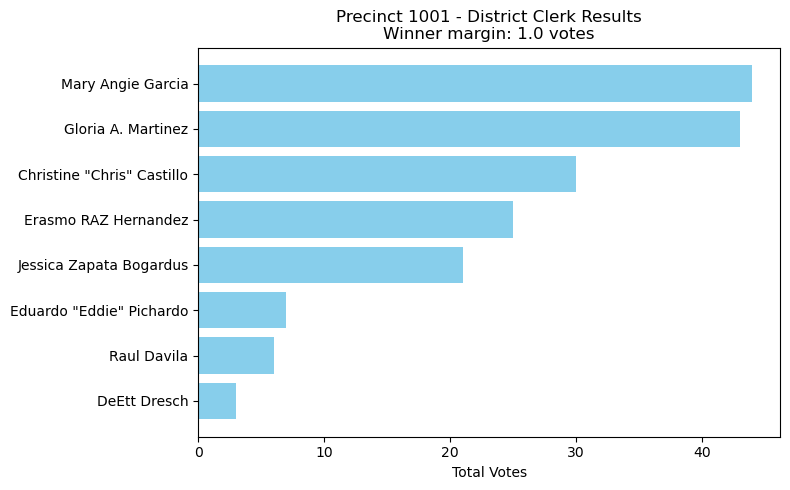

In [6]:
import matplotlib.pyplot as plt

# pull precinct 1001
p1001 = dc_long[dc_long["precinct"] == "1001"].copy()

# sort by total votes
p1001 = p1001.sort_values("total_votes", ascending=False)

# calculate margin between 1st and 2nd place
top = p1001.iloc[0]
runner_up = p1001.iloc[1]
margin = top["total_votes"] - runner_up["total_votes"]

print(f"Winner: {top['candidate']} with {top['total_votes']} votes")
print(f"Runner-up: {runner_up['candidate']} with {runner_up['total_votes']} votes")
print(f"Margin of victory: {margin} votes")

# --- Bar chart ---
plt.figure(figsize=(8,5))
plt.barh(p1001["candidate"], p1001["total_votes"], color="skyblue")
plt.gca().invert_yaxis()  # top candidate at top
plt.title(f"Precinct 1001 - District Clerk Results\nWinner margin: {margin} votes")
plt.xlabel("Total Votes")
plt.tight_layout()
plt.show()

Winner: Mary Angie Garcia with 44.0 votes
Runner-up: Gloria A. Martinez with 43.0 votes
Margin winner vs runner-up: 1.0 votes
Christine Castillo: 30.0 votes
Margin winner vs Castillo: 14.0 votes


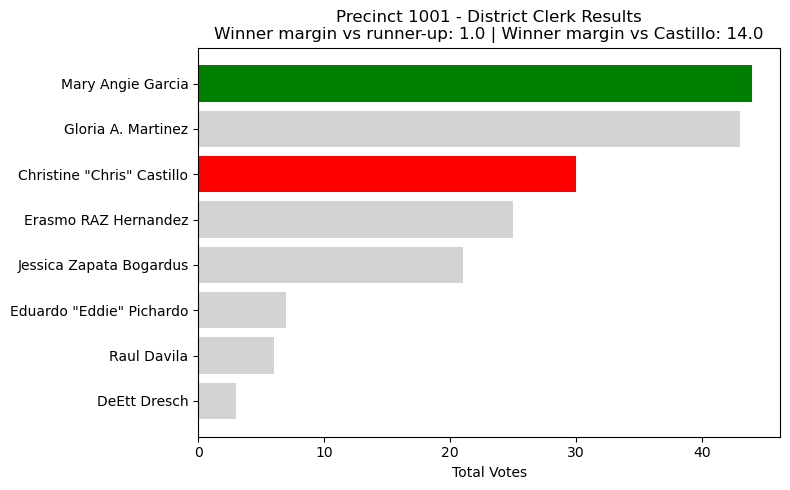

In [7]:
# Get precinct 1001 results
p1001 = dc_long[dc_long["precinct"] == "1001"].copy()
p1001 = p1001.sort_values("total_votes", ascending=False)

# Winner and runner-up
top = p1001.iloc[0]
runner_up = p1001.iloc[1]

# Christine Castillo’s row
castillo = p1001[p1001["candidate"].str.contains("Castillo", case=False)].iloc[0]

# Margins
margin_winner_runner = top["total_votes"] - runner_up["total_votes"]
margin_winner_castillo = top["total_votes"] - castillo["total_votes"]

print(f"Winner: {top['candidate']} with {top['total_votes']} votes")
print(f"Runner-up: {runner_up['candidate']} with {runner_up['total_votes']} votes")
print(f"Margin winner vs runner-up: {margin_winner_runner} votes")
print(f"Christine Castillo: {castillo['total_votes']} votes")
print(f"Margin winner vs Castillo: {margin_winner_castillo} votes")

# --- Bar chart ---
plt.figure(figsize=(8,5))
plt.barh(p1001["candidate"], p1001["total_votes"], color="lightgray")

# Highlight winner in green, Castillo in red
colors = ["green" if c == top["candidate"] else
          "red" if "Castillo" in c else
          "lightgray" for c in p1001["candidate"]]

plt.barh(p1001["candidate"], p1001["total_votes"], color=colors)

plt.gca().invert_yaxis()
plt.title(f"Precinct 1001 - District Clerk Results\n"
          f"Winner margin vs runner-up: {margin_winner_runner} | "
          f"Winner margin vs Castillo: {margin_winner_castillo}")
plt.xlabel("Total Votes")
plt.tight_layout()
plt.show()

Winner: Gloria A. Martinez with 37.0 votes
Runner-up: Mary Angie Garcia with 27.0 votes
Margin winner vs runner-up: 10.0 votes
Christine Castillo: 26.0 votes
Margin winner vs Castillo: 11.0 votes


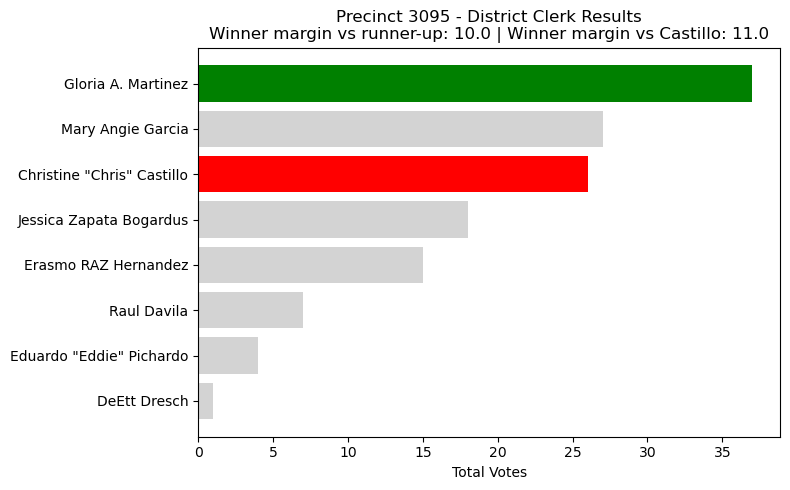

In [8]:
# Get precinct 1001 results
p3095 = dc_long[dc_long["precinct"] == "3095"].copy()
p3095 = p3095.sort_values("total_votes", ascending=False)

# Winner and runner-up
top = p3095.iloc[0]
runner_up = p3095.iloc[1]

# Christine Castillo’s row
castillo = p3095[p3095["candidate"].str.contains("Castillo", case=False)].iloc[0]

# Margins
margin_winner_runner = top["total_votes"] - runner_up["total_votes"]
margin_winner_castillo = top["total_votes"] - castillo["total_votes"]

print(f"Winner: {top['candidate']} with {top['total_votes']} votes")
print(f"Runner-up: {runner_up['candidate']} with {runner_up['total_votes']} votes")
print(f"Margin winner vs runner-up: {margin_winner_runner} votes")
print(f"Christine Castillo: {castillo['total_votes']} votes")
print(f"Margin winner vs Castillo: {margin_winner_castillo} votes")

# --- Bar chart ---
plt.figure(figsize=(8,5))
plt.barh(p3095["candidate"], p3095["total_votes"], color="lightgray")

# Highlight winner in green, Castillo in red
colors = ["green" if c == top["candidate"] else
          "red" if "Castillo" in c else
          "lightgray" for c in p3095["candidate"]]

plt.barh(p3095["candidate"], p3095["total_votes"], color=colors)

plt.gca().invert_yaxis()
plt.title(f"Precinct 3095 - District Clerk Results\n"
          f"Winner margin vs runner-up: {margin_winner_runner} | "
          f"Winner margin vs Castillo: {margin_winner_castillo}")
plt.xlabel("Total Votes")
plt.tight_layout()
plt.show()

In [9]:
# Make sure vote_pct is numeric
dc_long["vote_pct"] = pd.to_numeric(dc_long["vote_pct"], errors="coerce")

# Christine Castillo's rows
castillo = dc_long[dc_long["candidate"].str.contains("Castillo", case=False, na=False)].copy()

# Best and worst precincts by vote_pct
best = castillo.sort_values("vote_pct", ascending=False).iloc[0]
worst = castillo.sort_values("vote_pct", ascending=True).iloc[0]

# Helper: winner and margin vs Castillo for a precinct
def winner_and_margin(precinct):
    subset = dc_long[dc_long["precinct"] == precinct].sort_values("total_votes", ascending=False)
    winner = subset.iloc[0]
    castillo_votes = subset[subset["candidate"].str.contains("Castillo", case=False)].iloc[0]["total_votes"]
    margin = int(winner["total_votes"] - castillo_votes)
    return winner["candidate"], margin

# Winner + margin for best precinct
best_winner, best_margin = winner_and_margin(best["precinct"])

# Winner + margin for worst precinct
worst_winner, worst_margin = winner_and_margin(worst["precinct"])

# Results
print("== Christine Castillo Best Precinct ==")
print(f"Precinct {best['precinct']} | {best['vote_pct']:.2f}%")
print(f"Winner: {best_winner} | Margin vs Castillo: {best_margin} votes")

print("\n== Christine Castillo Worst Precinct ==")
print(f"Precinct {worst['precinct']} | {worst['vote_pct']:.2f}%")
print(f"Winner: {worst_winner} | Margin vs Castillo: {worst_margin} votes")

== Christine Castillo Best Precinct ==
Precinct 3140 | 100.00%
Winner: Christine "Chris" Castillo | Margin vs Castillo: 0 votes

== Christine Castillo Worst Precinct ==
Precinct 3150 | 0.00%
Winner: Mary Angie Garcia | Margin vs Castillo: 3 votes


------

### Overall Vote Counts

In [10]:
# make sure it's numeric
dc_long["total_votes"] = pd.to_numeric(dc_long["total_votes"], errors="coerce").fillna(0)

# total votes per precinct (all candidates summed)
precinct_totals = (
    dc_long.groupby("precinct", as_index=False)["total_votes"].sum()
            .rename(columns={"total_votes":"precinct_total"})
)

# stats
avg_votes   = precinct_totals["precinct_total"].mean()
median_votes= precinct_totals["precinct_total"].median()
highest     = precinct_totals.loc[precinct_totals["precinct_total"].idxmax()]
lowest      = precinct_totals.loc[precinct_totals["precinct_total"].idxmin()]

print(f"Average total votes per precinct: {avg_votes:.1f}")
print(f"Median total votes per precinct: {median_votes:.1f}")

print("\n== Highest Turnout Precinct ==")
print(f"Precinct {highest['precinct']} | {int(highest['precinct_total'])} total votes")

print("\n== Lowest Turnout Precinct ==")
print(f"Precinct {lowest['precinct']} | {int(lowest['precinct_total'])} total votes")

Average total votes per precinct: 112.2
Median total votes per precinct: 105.0

== Highest Turnout Precinct ==
Precinct 2068 | 418 total votes

== Lowest Turnout Precinct ==
Precinct 1090 | 0 total votes


----

### IQR for Votes

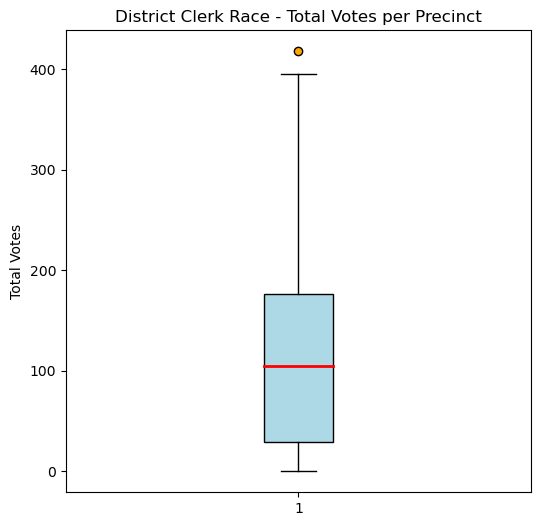

Q1 (25th percentile): 28.75
Q3 (75th percentile): 176.0
IQR: 147.25


In [11]:
# ensure totals are numeric
dc_long["total_votes"] = pd.to_numeric(dc_long["total_votes"], errors="coerce").fillna(0)

# total votes per precinct (all candidates combined)
precinct_totals = (
    dc_long.groupby("precinct", as_index=False)["total_votes"].sum()
            .rename(columns={"total_votes":"precinct_total"})
)

# Boxplot
plt.figure(figsize=(6,6))
plt.boxplot(precinct_totals["precinct_total"], vert=True, patch_artist=True,
            boxprops=dict(facecolor="lightblue"),
            medianprops=dict(color="red", linewidth=2),
            whiskerprops=dict(color="black"),
            capprops=dict(color="black"),
            flierprops=dict(markerfacecolor="orange", marker="o", markersize=6, linestyle="none"))

plt.title("District Clerk Race - Total Votes per Precinct")
plt.ylabel("Total Votes")
plt.show()

# Calculate IQR
q1 = precinct_totals["precinct_total"].quantile(0.25)
q3 = precinct_totals["precinct_total"].quantile(0.75)
iqr = q3 - q1

print(f"Q1 (25th percentile): {q1}")
print(f"Q3 (75th percentile): {q3}")
print(f"IQR: {iqr}")

### Best and Worst Precincts including IQR

In [12]:
# Total votes per precinct (turnout)
precinct_totals = dc_long.groupby("precinct", as_index=False)["total_votes"].sum().rename(columns={"total_votes":"precinct_total"})

# Merge Castillo performance with totals
castillo = dc_long[dc_long["candidate"].str.contains("Castillo", case=False, na=False)].copy()
castillo = castillo.merge(precinct_totals, on="precinct", how="left")

# Calculate vote_pct if not already numeric
castillo["vote_pct"] = pd.to_numeric(castillo["vote_pct"], errors="coerce")

# IQR bounds
q1 = precinct_totals["precinct_total"].quantile(0.25)
q3 = precinct_totals["precinct_total"].quantile(0.75)

# Keep precincts within IQR
castillo_iqr = castillo[(castillo["precinct_total"] >= q1) & (castillo["precinct_total"] <= q3)]

In [13]:
best = castillo_iqr.loc[castillo_iqr["vote_pct"].idxmax()]
worst = castillo_iqr.loc[castillo_iqr["vote_pct"].idxmin()]

def winner_and_margin(precinct):
    subset = dc_long[dc_long["precinct"] == precinct].sort_values("total_votes", ascending=False)
    winner = subset.iloc[0]
    castillo_votes = subset[subset["candidate"].str.contains("Castillo", case=False)].iloc[0]["total_votes"]
    margin = int(winner["total_votes"] - castillo_votes)
    return winner["candidate"], margin

best_winner, best_margin = winner_and_margin(best["precinct"])
worst_winner, worst_margin = winner_and_margin(worst["precinct"])

print("== Castillo BEST precinct (within IQR turnout) ==")
print(f"Precinct {best['precinct']} | {best['vote_pct']:.2f}% "
      f"({int(best['total_votes'])}/{int(best['precinct_total'])})")
print(f"Winner: {best_winner} | Margin: {best_margin} votes")

print("\n== Castillo WORST precinct (within IQR turnout) ==")
print(f"Precinct {worst['precinct']} | {worst['vote_pct']:.2f}% "
      f"({int(worst['total_votes'])}/{int(worst['precinct_total'])})")
print(f"Winner: {worst_winner} | Margin: {worst_margin} votes")

== Castillo BEST precinct (within IQR turnout) ==
Precinct 2093 | 41.33% (31/75)
Winner: Christine "Chris" Castillo | Margin: 0 votes

== Castillo WORST precinct (within IQR turnout) ==
Precinct 1117 | 7.32% (3/41)
Winner: Gloria A. Martinez | Margin: 10 votes


Winner: Christine "Chris" Castillo with 31.0 votes
Runner-up: Gloria A. Martinez with 19.0 votes
Margin winner vs runner-up: 12.0 votes
Christine Castillo: 31.0 votes
Margin winner vs Castillo: 0.0 votes


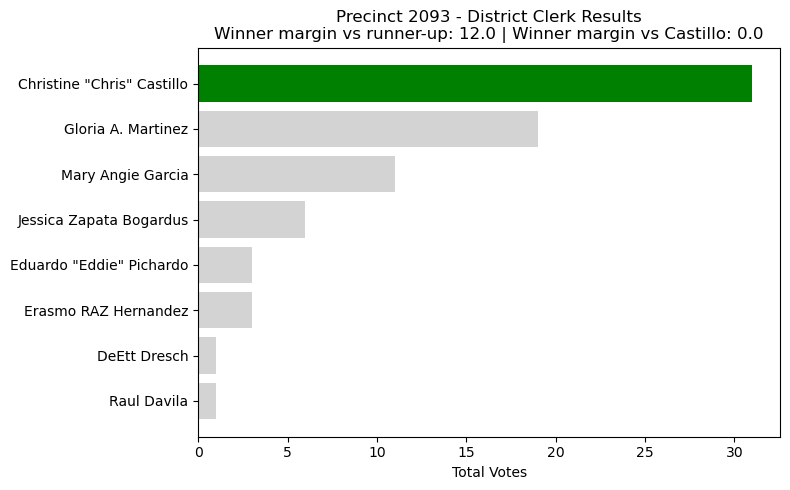

In [14]:
# Get precinct 1001 results
p2093 = dc_long[dc_long["precinct"] == "2093"].copy()
p2093 = p2093.sort_values("total_votes", ascending=False)

# Winner and runner-up
top = p2093.iloc[0]
runner_up = p2093.iloc[1]

# Christine Castillo’s row
castillo = p2093[p2093["candidate"].str.contains("Castillo", case=False)].iloc[0]

# Margins
margin_winner_runner = top["total_votes"] - runner_up["total_votes"]
margin_winner_castillo = top["total_votes"] - castillo["total_votes"]

print(f"Winner: {top['candidate']} with {top['total_votes']} votes")
print(f"Runner-up: {runner_up['candidate']} with {runner_up['total_votes']} votes")
print(f"Margin winner vs runner-up: {margin_winner_runner} votes")
print(f"Christine Castillo: {castillo['total_votes']} votes")
print(f"Margin winner vs Castillo: {margin_winner_castillo} votes")

# --- Bar chart ---
plt.figure(figsize=(8,5))
plt.barh(p2093["candidate"], p2093["total_votes"], color="lightgray")

# Highlight winner in green, Castillo in red
colors = ["green" if c == top["candidate"] else
          "red" if "Castillo" in c else
          "lightgray" for c in p2093["candidate"]]

plt.barh(p2093["candidate"], p2093["total_votes"], color=colors)

plt.gca().invert_yaxis()
plt.title(f"Precinct 2093 - District Clerk Results\n"
          f"Winner margin vs runner-up: {margin_winner_runner} | "
          f"Winner margin vs Castillo: {margin_winner_castillo}")
plt.xlabel("Total Votes")
plt.tight_layout()
plt.show()

### Worst Performing Precinct

Winner: Gloria A. Martinez with 13.0 votes
Runner-up: Mary Angie Garcia with 8.0 votes
Margin winner vs runner-up: 5.0 votes
Christine Castillo: 3.0 votes
Margin winner vs Castillo: 10.0 votes


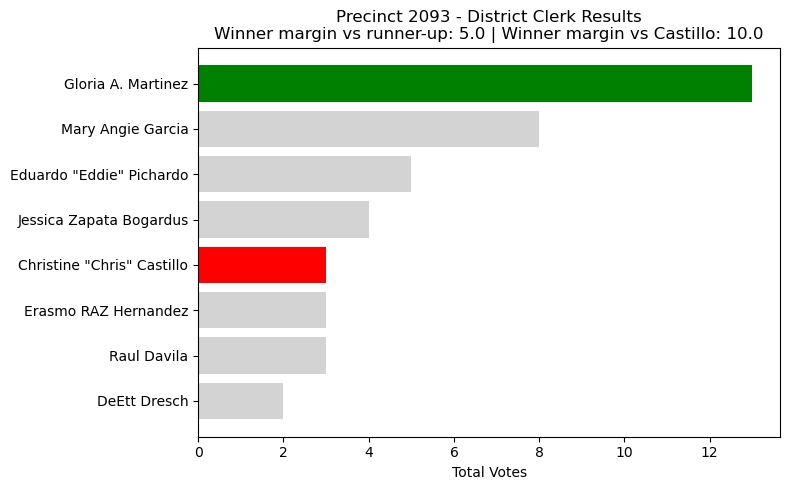

In [15]:
# Get precinct 1001 results
p1117 = dc_long[dc_long["precinct"] == "1117"].copy()
p1117 = p1117.sort_values("total_votes", ascending=False)

# Winner and runner-up
top = p1117.iloc[0]
runner_up = p1117.iloc[1]

# Christine Castillo’s row
castillo = p1117[p1117["candidate"].str.contains("Castillo", case=False)].iloc[0]

# Margins
margin_winner_runner = top["total_votes"] - runner_up["total_votes"]
margin_winner_castillo = top["total_votes"] - castillo["total_votes"]

print(f"Winner: {top['candidate']} with {top['total_votes']} votes")
print(f"Runner-up: {runner_up['candidate']} with {runner_up['total_votes']} votes")
print(f"Margin winner vs runner-up: {margin_winner_runner} votes")
print(f"Christine Castillo: {castillo['total_votes']} votes")
print(f"Margin winner vs Castillo: {margin_winner_castillo} votes")

# --- Bar chart ---
plt.figure(figsize=(8,5))
plt.barh(p1117["candidate"], p1117["total_votes"], color="lightgray")

# Highlight winner in green, Castillo in red
colors = ["green" if c == top["candidate"] else
          "red" if "Castillo" in c else
          "lightgray" for c in p1117["candidate"]]

plt.barh(p1117["candidate"], p1117["total_votes"], color=colors)

plt.gca().invert_yaxis()
plt.title(f"Precinct 2093 - District Clerk Results\n"
          f"Winner margin vs runner-up: {margin_winner_runner} | "
          f"Winner margin vs Castillo: {margin_winner_castillo}")
plt.xlabel("Total Votes")
plt.tight_layout()
plt.show()

In [16]:
# Make sure vote_pct is numeric
dc_long["vote_pct"] = pd.to_numeric(dc_long["vote_pct"], errors="coerce")

# Filter for Christine Castillo
castillo = dc_long[dc_long["candidate"].str.contains("Castillo", case=False, na=False)].copy()

# Sort precincts by vote percentage
top10 = castillo.sort_values("vote_pct", ascending=False).head(10)
bottom10 = castillo.sort_values("vote_pct", ascending=True).head(10)

print("=== Christine Castillo - TOP 10 Precincts by Vote % ===")
display(top10[["precinct", "vote_pct", "total_votes", "election_day", "absentee", "early_voting"]])

print("\n=== Christine Castillo - BOTTOM 10 Precincts by Vote % ===")
display(bottom10[["precinct", "vote_pct", "total_votes", "election_day", "absentee", "early_voting"]])

=== Christine Castillo - TOP 10 Precincts by Vote % ===


,precinct,vote_pct,total_votes,election_day,absentee,early_voting
3840,3140,100.0,1.0,0.0,0.0,1.0
2472,2151,100.0,1.0,0.0,0.0,1.0
6040,4210,100.0,2.0,2.0,0.0,0.0
3984,3158,50.0,2.0,0.0,0.0,2.0
6096,4217,50.0,2.0,0.0,1.0,1.0
5696,4167,50.0,1.0,0.0,0.0,1.0
5680,4165,50.0,2.0,2.0,0.0,0.0
3824,3138,50.0,2.0,1.0,0.0,1.0
3896,3147,50.0,2.0,1.0,0.0,1.0
2696,2179,50.0,3.0,1.0,0.0,2.0



=== Christine Castillo - BOTTOM 10 Precincts by Vote % ===


,precinct,vote_pct,total_votes,election_day,absentee,early_voting
3920,3150,0.0,0.0,0.0,0.0,0.0
5392,4129,0.0,0.0,0.0,0.0,0.0
5376,4127,0.0,0.0,0.0,0.0,0.0
5360,4125,0.0,0.0,0.0,0.0,0.0
5288,4116,0.0,0.0,0.0,0.0,0.0
5248,4111,0.0,0.0,0.0,0.0,0.0
488,1062,0.0,0.0,0.0,0.0,0.0
584,1074,0.0,0.0,0.0,0.0,0.0
4536,4022,0.0,0.0,0.0,0.0,0.0
232,1030,0.0,0.0,0.0,0.0,0.0


In [17]:
import pandas as pd

# Make sure numeric
dc_long["total_votes"] = pd.to_numeric(dc_long["total_votes"], errors="coerce").fillna(0)
dc_long["vote_pct"] = pd.to_numeric(dc_long["vote_pct"], errors="coerce").fillna(0)

# Total votes per precinct (overall turnout)
precinct_totals = (
    dc_long.groupby("precinct", as_index=False)["total_votes"].sum()
           .rename(columns={"total_votes":"precinct_total"})
)

# Merge into Castillo data
castillo = (
    dc_long[dc_long["candidate"].str.contains("Castillo", case=False, na=False)]
    .merge(precinct_totals, on="precinct", how="left")
)

# Compute IQR
q1 = precinct_totals["precinct_total"].quantile(0.20)
q3 = precinct_totals["precinct_total"].quantile(0.95)
iqr = q3 - q1

print(f"Lower IQR bound (Q1): {q1:.2f}")
print(f"Upper IQR bound (Q3): {q3:.2f}")
print(f"IQR range: {iqr:.2f}")

# Keep only precincts within IQR range
castillo_iqr = castillo[(castillo["precinct_total"] >= q1) & (castillo["precinct_total"] <= q3)]


# Rank precincts by vote_pct (within turnout IQR)
top10 = castillo_iqr.sort_values("vote_pct", ascending=False).head(10)
bottom10 = castillo_iqr.sort_values("vote_pct", ascending=True).head(10)

print("=== Christine Castillo - TOP 10 Precincts by Vote % (within IQR turnout) ===")
display(top10[["precinct", "vote_pct", "total_votes", "precinct_total", "election_day", "absentee", "early_voting"]])

print("\n=== Chris Castillo - BOTTOM 10 Precincts by Vote % (within IQR turnout) ===")
display(bottom10[["precinct", "vote_pct", "total_votes", "precinct_total", "election_day", "absentee", "early_voting"]])

Lower IQR bound (Q1): 17.00
Upper IQR bound (Q3): 268.25
IQR range: 251.25
=== Christine Castillo - TOP 10 Precincts by Vote % (within IQR turnout) ===


,precinct,vote_pct,total_votes,precinct_total,election_day,absentee,early_voting
251,2093,41.33,31.0,75.0,19.0,2.0,10.0
126,1127,40.38,21.0,52.0,10.0,1.0,10.0
26,1027,38.24,13.0,34.0,7.0,0.0,6.0
651,4106,37.93,11.0,29.0,5.0,2.0,4.0
559,4014,35.00,14.0,40.0,3.0,1.0,10.0
170,2012,31.73,33.0,104.0,11.0,1.0,21.0
673,4128,31.58,6.0,19.0,3.0,0.0,3.0
4,1005,31.25,25.0,80.0,12.0,1.0,12.0
102,1103,31.11,14.0,45.0,6.0,1.0,7.0
21,1022,30.88,21.0,68.0,9.0,5.0,7.0



=== Chris Castillo - BOTTOM 10 Precincts by Vote % (within IQR turnout) ===


,precinct,vote_pct,total_votes,precinct_total,election_day,absentee,early_voting
250,2092,4.55,1.0,22.0,0.0,0.0,1.0
692,4147,5.26,1.0,19.0,0.0,0.0,1.0
116,1117,7.32,3.0,41.0,1.0,0.0,2.0
525,3185,7.41,2.0,27.0,0.0,1.0,1.0
354,3014,7.55,4.0,53.0,1.0,0.0,3.0
631,4086,8.70,2.0,23.0,2.0,0.0,0.0
664,4119,8.70,4.0,46.0,0.0,0.0,4.0
350,3010,8.70,2.0,23.0,0.0,0.0,2.0
141,1142,8.79,8.0,91.0,6.0,1.0,1.0
721,4176,9.21,7.0,76.0,3.0,0.0,4.0


In [18]:
# Assuming your DataFrame is named castillo_iqr or similar
cols_to_int = ["total_votes", "precinct_total", "election_day", "absentee", "early_voting"]

# Convert selected columns to int (ignore NaN safely)
for col in cols_to_int:
    castillo_iqr[col] = castillo_iqr[col].fillna(0).astype(int)


/var/folders/tq/b0dt2mpn2d1d4_1c638syx_h0000gp/T/ipykernel_13083/816114205.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  castillo_iqr[col] = castillo_iqr[col].fillna(0).astype(int)


In [19]:
print("\n=== Christine Castillo - BOTTOM 10 Precincts by Vote % (within IQR turnout) ===")
display(bottom10[["precinct", "vote_pct", "total_votes", "precinct_total", "election_day", "absentee", "early_voting"]])


=== Christine Castillo - BOTTOM 10 Precincts by Vote % (within IQR turnout) ===


,precinct,vote_pct,total_votes,precinct_total,election_day,absentee,early_voting
250,2092,4.55,1.0,22.0,0.0,0.0,1.0
692,4147,5.26,1.0,19.0,0.0,0.0,1.0
116,1117,7.32,3.0,41.0,1.0,0.0,2.0
525,3185,7.41,2.0,27.0,0.0,1.0,1.0
354,3014,7.55,4.0,53.0,1.0,0.0,3.0
631,4086,8.70,2.0,23.0,2.0,0.0,0.0
664,4119,8.70,4.0,46.0,0.0,0.0,4.0
350,3010,8.70,2.0,23.0,0.0,0.0,2.0
141,1142,8.79,8.0,91.0,6.0,1.0,1.0
721,4176,9.21,7.0,76.0,3.0,0.0,4.0


In [20]:
castillo_iqr_display = castillo_iqr.copy()
castillo_iqr_display[cols_to_int] = castillo_iqr_display[cols_to_int].astype(int)

display(castillo_iqr_display.head(10))

,precinct,candidate,total_votes,vote_pct,election_day,absentee,early_voting,precinct_total
0,1001,"Christine ""Chris"" Castillo",30,16.76,15,1,14,179
1,1002,"Christine ""Chris"" Castillo",12,19.05,4,3,5,63
2,1003,"Christine ""Chris"" Castillo",62,29.52,34,0,28,210
3,1004,"Christine ""Chris"" Castillo",18,18.95,11,1,6,95
4,1005,"Christine ""Chris"" Castillo",25,31.25,12,1,12,80
5,1006,"Christine ""Chris"" Castillo",53,26.77,26,7,20,198
6,1007,"Christine ""Chris"" Castillo",30,23.44,15,2,13,128
8,1009,"Christine ""Chris"" Castillo",13,15.29,8,1,4,85
9,1010,"Christine ""Chris"" Castillo",23,27.38,8,0,15,84
10,1011,"Christine ""Chris"" Castillo",18,17.48,11,2,5,103


In [21]:
castillo_iqr.head()

,precinct,candidate,total_votes,vote_pct,election_day,absentee,early_voting,precinct_total
0,1001,"Christine ""Chris"" Castillo",30,16.76,15,1,14,179
1,1002,"Christine ""Chris"" Castillo",12,19.05,4,3,5,63
2,1003,"Christine ""Chris"" Castillo",62,29.52,34,0,28,210
3,1004,"Christine ""Chris"" Castillo",18,18.95,11,1,6,95
4,1005,"Christine ""Chris"" Castillo",25,31.25,12,1,12,80


In [22]:
castillo_iqr.sort_values("vote_pct", ascending=True)

,precinct,candidate,total_votes,vote_pct,election_day,absentee,early_voting,precinct_total
250,2092,"Christine ""Chris"" Castillo",1,4.55,0,0,1,22
692,4147,"Christine ""Chris"" Castillo",1,5.26,0,0,1,19
116,1117,"Christine ""Chris"" Castillo",3,7.32,1,0,2,41
525,3185,"Christine ""Chris"" Castillo",2,7.41,0,1,1,27
354,3014,"Christine ""Chris"" Castillo",4,7.55,1,0,3,53
...,...,...,...,...,...,...,...,...
559,4014,"Christine ""Chris"" Castillo",14,35.00,3,1,10,40
651,4106,"Christine ""Chris"" Castillo",11,37.93,5,2,4,29
26,1027,"Christine ""Chris"" Castillo",13,38.24,7,0,6,34
126,1127,"Christine ""Chris"" Castillo",21,40.38,10,1,10,52


In [23]:
castillo.sort_values("vote_pct", ascending=True)

,precinct,candidate,total_votes,vote_pct,election_day,absentee,early_voting,precinct_total
130,1131,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,0.0
685,4140,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,0.0
313,2155,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,0.0
690,4145,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,0.0
691,4146,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
478,3138,"Christine ""Chris"" Castillo",2.0,50.0,1.0,0.0,1.0,4.0
337,2179,"Christine ""Chris"" Castillo",3.0,50.0,1.0,0.0,2.0,6.0
480,3140,"Christine ""Chris"" Castillo",1.0,100.0,0.0,0.0,1.0,1.0
755,4210,"Christine ""Chris"" Castillo",2.0,100.0,2.0,0.0,0.0,2.0


In [24]:
# Split out precincts with zero total votes
zero_votes_df = castillo[castillo["precinct_total"] == 0].copy()
castillo = castillo[castillo["precinct_total"] > 0].copy()

# Count them
zero_count = len(zero_votes_df)
print(f"Removed {zero_count} precincts with 0 precinct total votes.")

# check first few zero-vote precincts
display(zero_votes_df.head())

Removed 81 precincts with 0 precinct total votes.


,precinct,candidate,total_votes,vote_pct,election_day,absentee,early_voting,precinct_total
89,1090,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,0.0
100,1101,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,0.0
105,1106,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,0.0
108,1109,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,0.0
125,1126,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
castillo.sort_values("vote_pct", ascending=True).head(20)

,precinct,candidate,total_votes,vote_pct,election_day,absentee,early_voting,precinct_total
490,3150,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,6.0
674,4129,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,7.0
672,4127,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,4.0
670,4125,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,5.0
661,4116,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,7.0
656,4111,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,16.0
61,1062,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,4.0
73,1074,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,2.0
567,4022,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,5.0
29,1030,"Christine ""Chris"" Castillo",0.0,0.0,0.0,0.0,0.0,3.0


In [32]:
# Separate precincts with fewer than 10 total votes
under_10_total_df = castillo[castillo["precinct_total"] < 10].copy()

# Keep only precincts with 10 or more total votes
over_10_total_df = castillo[castillo["precinct_total"] >= 10].copy()

# Count how many were removed
print(f"Removed {len(under_10_total_df)} precincts with fewer than 10 total votes.")
print(f"Remaining precincts: {len(over_10_total_df)}")

# peek at the low-turnout ones
display(under_10_total_df.head())

# Optional: peek at the cleaned dataset sorted by vote_pct
display(over_10_total_df.sort_values("vote_pct", ascending=True).head(10))

Removed 59 precincts with fewer than 10 total votes.
Remaining precincts: 636


,precinct,candidate,total_votes,vote_pct,election_day,absentee,early_voting,precinct_total
29,1030,"Christine ""Chris"" Castillo",0.0,0.00,0.0,0.0,0.0,3.0
58,1059,"Christine ""Chris"" Castillo",3.0,33.33,1.0,0.0,2.0,9.0
61,1062,"Christine ""Chris"" Castillo",0.0,0.00,0.0,0.0,0.0,4.0
73,1074,"Christine ""Chris"" Castillo",0.0,0.00,0.0,0.0,0.0,2.0
88,1089,"Christine ""Chris"" Castillo",2.0,22.22,1.0,0.0,1.0,9.0


,precinct,candidate,total_votes,vote_pct,election_day,absentee,early_voting,precinct_total
656,4111,"Christine ""Chris"" Castillo",0.0,0.00,0.0,0.0,0.0,16.0
250,2092,"Christine ""Chris"" Castillo",1.0,4.55,0.0,0.0,1.0,22.0
692,4147,"Christine ""Chris"" Castillo",1.0,5.26,0.0,0.0,1.0,19.0
686,4141,"Christine ""Chris"" Castillo",1.0,7.14,0.0,0.0,1.0,14.0
116,1117,"Christine ""Chris"" Castillo",3.0,7.32,1.0,0.0,2.0,41.0
525,3185,"Christine ""Chris"" Castillo",2.0,7.41,0.0,1.0,1.0,27.0
354,3014,"Christine ""Chris"" Castillo",4.0,7.55,1.0,0.0,3.0,53.0
665,4120,"Christine ""Chris"" Castillo",1.0,8.33,0.0,1.0,0.0,12.0
664,4119,"Christine ""Chris"" Castillo",4.0,8.70,0.0,0.0,4.0,46.0
631,4086,"Christine ""Chris"" Castillo",2.0,8.70,2.0,0.0,0.0,23.0



=== Precinct 4111 ===
Winner: Gloria A. Martinez with 7 votes
Runner-up: Erasmo RAZ Hernandez with 3 votes
Margin of victory: 4 votes


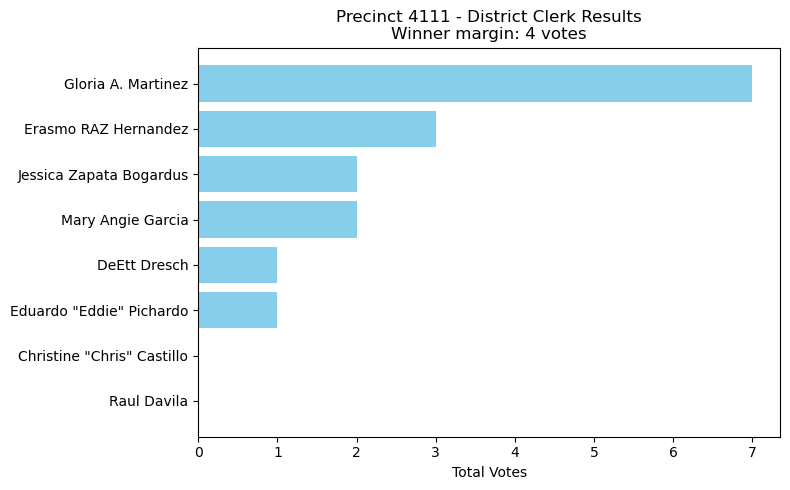


=== Precinct 2092 ===
Winner: Gloria A. Martinez with 7 votes
Runner-up: Mary Angie Garcia with 6 votes
Margin of victory: 1 votes


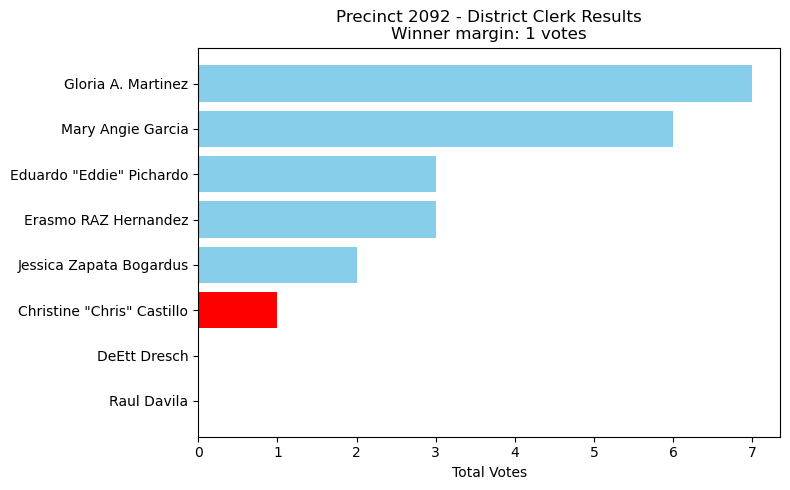


=== Precinct 4147 ===
Winner: Erasmo RAZ Hernandez with 6 votes
Runner-up: Gloria A. Martinez with 6 votes
Margin of victory: 0 votes


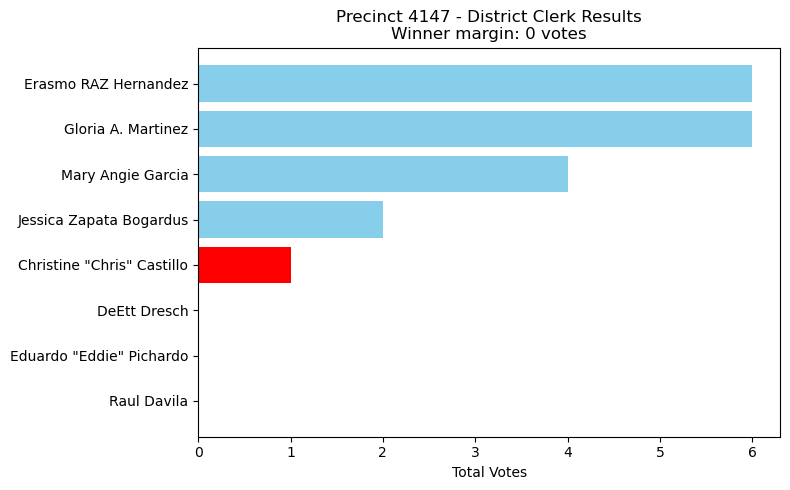


=== Precinct 4141 ===
Winner: Gloria A. Martinez with 5 votes
Runner-up: Raul Davila with 3 votes
Margin of victory: 2 votes


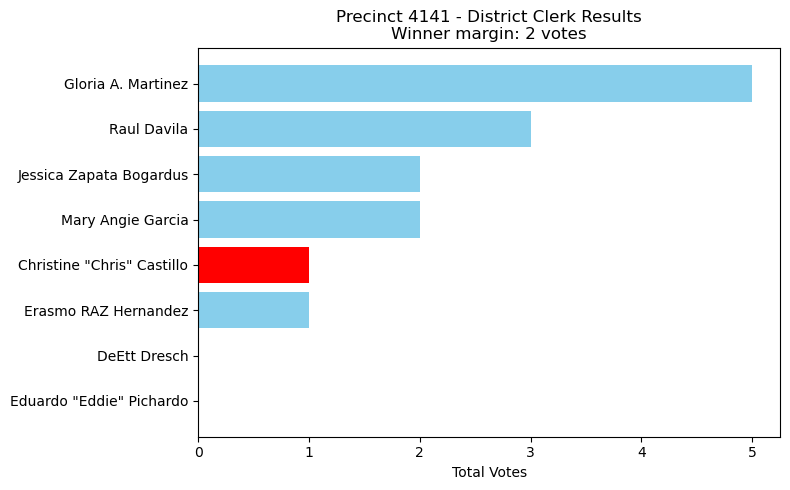


=== Precinct 1117 ===
Winner: Gloria A. Martinez with 13 votes
Runner-up: Mary Angie Garcia with 8 votes
Margin of victory: 5 votes


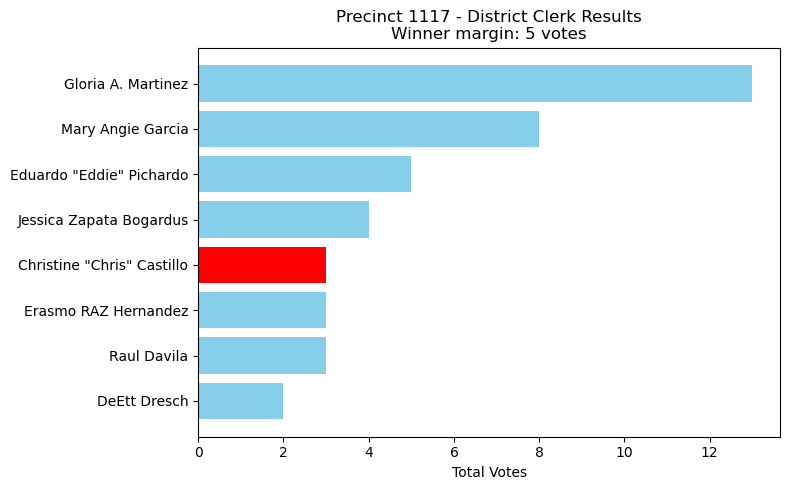


=== Precinct 3185 ===
Winner: Mary Angie Garcia with 6 votes
Runner-up: Gloria A. Martinez with 5 votes
Margin of victory: 1 votes


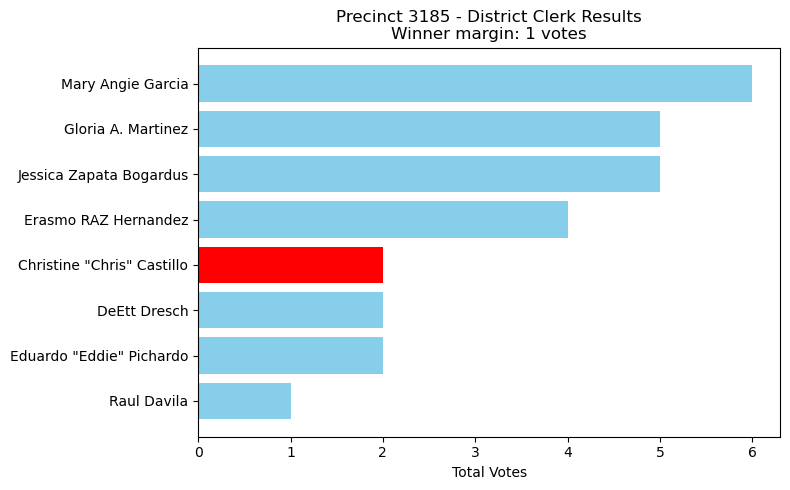


=== Precinct 3014 ===
Winner: Gloria A. Martinez with 17 votes
Runner-up: Mary Angie Garcia with 12 votes
Margin of victory: 5 votes


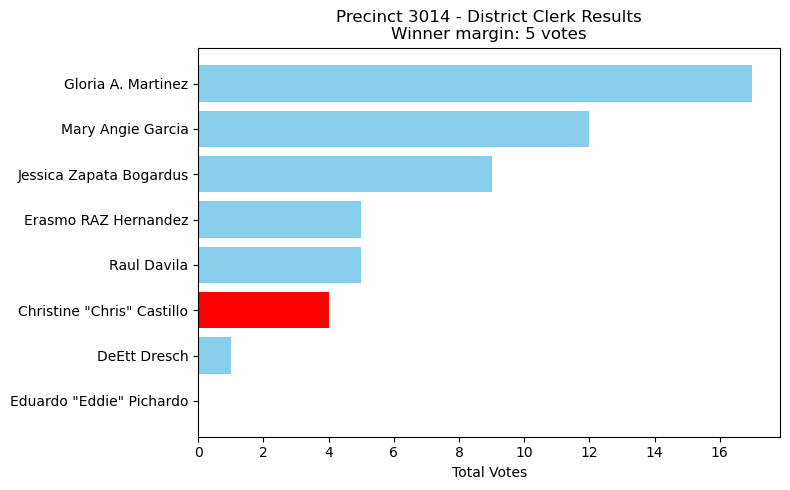


=== Precinct 4120 ===
Winner: Gloria A. Martinez with 4 votes
Runner-up: Mary Angie Garcia with 2 votes
Margin of victory: 2 votes


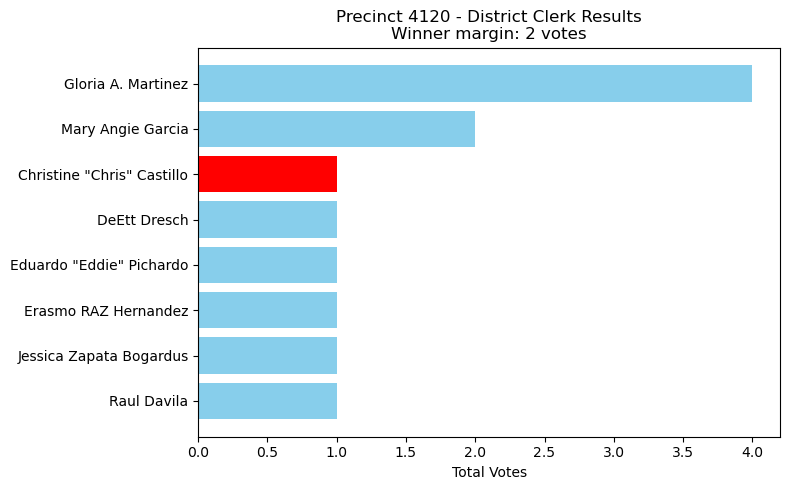


=== Precinct 4119 ===
Winner: Jessica Zapata Bogardus with 13 votes
Runner-up: Gloria A. Martinez with 10 votes
Margin of victory: 3 votes


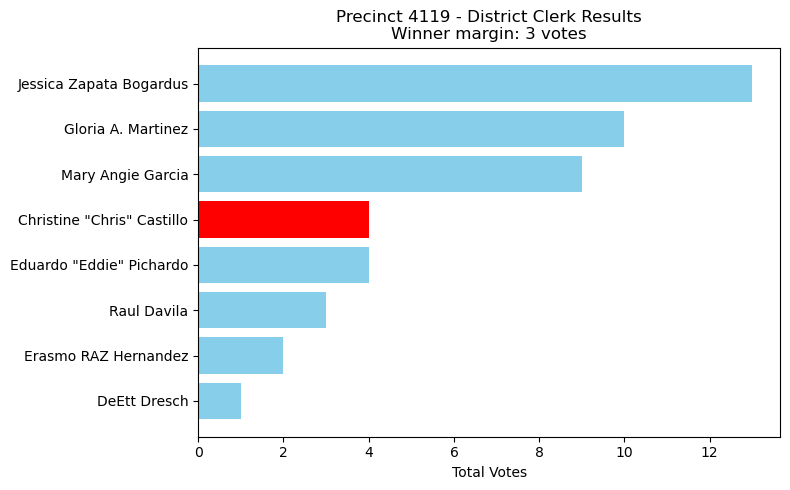


=== Precinct 4086 ===
Winner: Gloria A. Martinez with 8 votes
Runner-up: Jessica Zapata Bogardus with 6 votes
Margin of victory: 2 votes


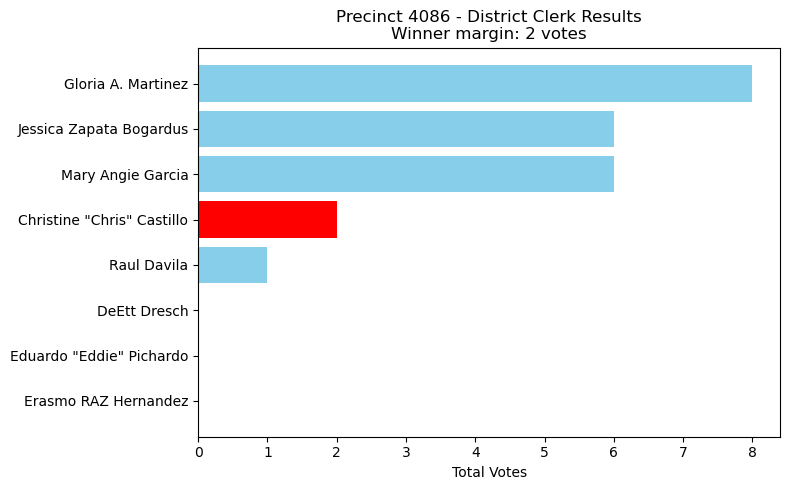

In [34]:
import matplotlib.pyplot as plt

# List of precincts to analyze
precinct_list = ["4111", "2092", "4147", "4141", "1117", "3185", "3014", "4120", "4119", "4086"]

for precinct in precinct_list:
    p_df = dc_long[dc_long["precinct"] == precinct].copy()
    
    # Skip if precinct not found or has no data
    if p_df.empty:
        print(f"⚠️ Precinct {precinct} not found or has no data.")
        continue
    
    # Sort by total votes (highest to lowest)
    p_df = p_df.sort_values("total_votes", ascending=False)
    
    # Ensure at least two candidates to calculate margin
    if len(p_df) < 2:
        print(f"⚠️ Precinct {precinct} has fewer than 2 candidates.")
        continue

    # Winner & runner-up
    top = p_df.iloc[0]
    runner_up = p_df.iloc[1]
    margin = int(top["total_votes"] - runner_up["total_votes"])

    # Print summary
    print(f"\n=== Precinct {precinct} ===")
    print(f"Winner: {top['candidate']} with {int(top['total_votes'])} votes")
    print(f"Runner-up: {runner_up['candidate']} with {int(runner_up['total_votes'])} votes")
    print(f"Margin of victory: {margin} votes")

    # --- Bar chart ---
    plt.figure(figsize=(8, 5))

    # Color bars: red for Castillo, blue for others
    colors = [
        "red" if "castillo" in str(c).lower() else "skyblue"
        for c in p_df["candidate"]
    ]

    plt.barh(p_df["candidate"], p_df["total_votes"], color=colors)
    plt.gca().invert_yaxis()
    plt.title(f"Precinct {precinct} - District Clerk Results\nWinner margin: {margin} votes")
    plt.xlabel("Total Votes")
    plt.tight_layout()
    plt.show()

In [35]:
# Castillo share by precinct (using your existing dc_long with vote_pct)
castillo_pct = (
    dc_long[dc_long["candidate"].str.contains("Castillo", case=False, na=False)]
      .loc[:, ["precinct", "vote_pct"]]
      .drop_duplicates(subset=["precinct"])  # 1 row per precinct
      .assign(precinct=lambda d: d["precinct"].astype(str).str.strip())
)

In [38]:
import geopandas as gpd
import pandas as pd
import re

gdf = gpd.read_file("Bexar_County_Voter_Precincts.geojson")
print("Geo columns:", list(gdf.columns)[:20])
print(gdf.head(2).T)  # quick peek

# Auto-detect precinct column: look for a column that contains 4-digit precinct codes
def find_precinct_col(g):
    candidates = []
    for col in g.columns:
        if col == g.geometry.name: 
            continue
        s = g[col].astype(str).str.strip()
        # extract 4 consecutive digits if present (handles 'PCT 1001' or 'Precinct: 1001')
        extracted = s.str.extract(r'(\d{4})', expand=False)
        hit_rate = extracted.notna().mean()
        # prefer columns where a big chunk of rows look like 4-digit codes
        if hit_rate > 0.5:   # adjust if needed
            candidates.append((col, hit_rate))
    # pick the best hit
    if candidates:
        candidates.sort(key=lambda x: x[1], reverse=True)
        return candidates[0][0]
    return None

prec_col = find_precinct_col(gdf)
print("Detected precinct column:", prec_col)

# Create a clean 'precinct' key (string 4-digit) from that column
if prec_col is None:
    raise ValueError("Couldn't auto-detect a precinct column. Check gdf.columns and tell me which field is the precinct code.")
gdf["precinct"] = gdf[prec_col].astype(str).str.extract(r'(\d{4})', expand=False)
gdf = gdf[gdf["precinct"].notna()].copy()
gdf["precinct"] = gdf["precinct"].str.strip()

Geo columns: ['OBJECTID', 'NAME', 'STATESENAT', 'CONG', 'STATEREP', 'ShapeSTArea', 'ShapeSTLength', 'geometry']
                                                               0  \
OBJECTID                                                       1   
NAME                                                        1066   
STATESENAT                                                    19   
CONG                                                          23   
STATEREP                                                     118   
ShapeSTArea                                     195964896.996094   
ShapeSTLength                                       85065.064879   
geometry       POLYGON ((-98.71505582047617 29.27102698578922...   

                                                               1  
OBJECTID                                                       2  
NAME                                                        1067  
STATESENAT                                                    19  
CONG   

Polygons: 776  | with Castillo %: 776


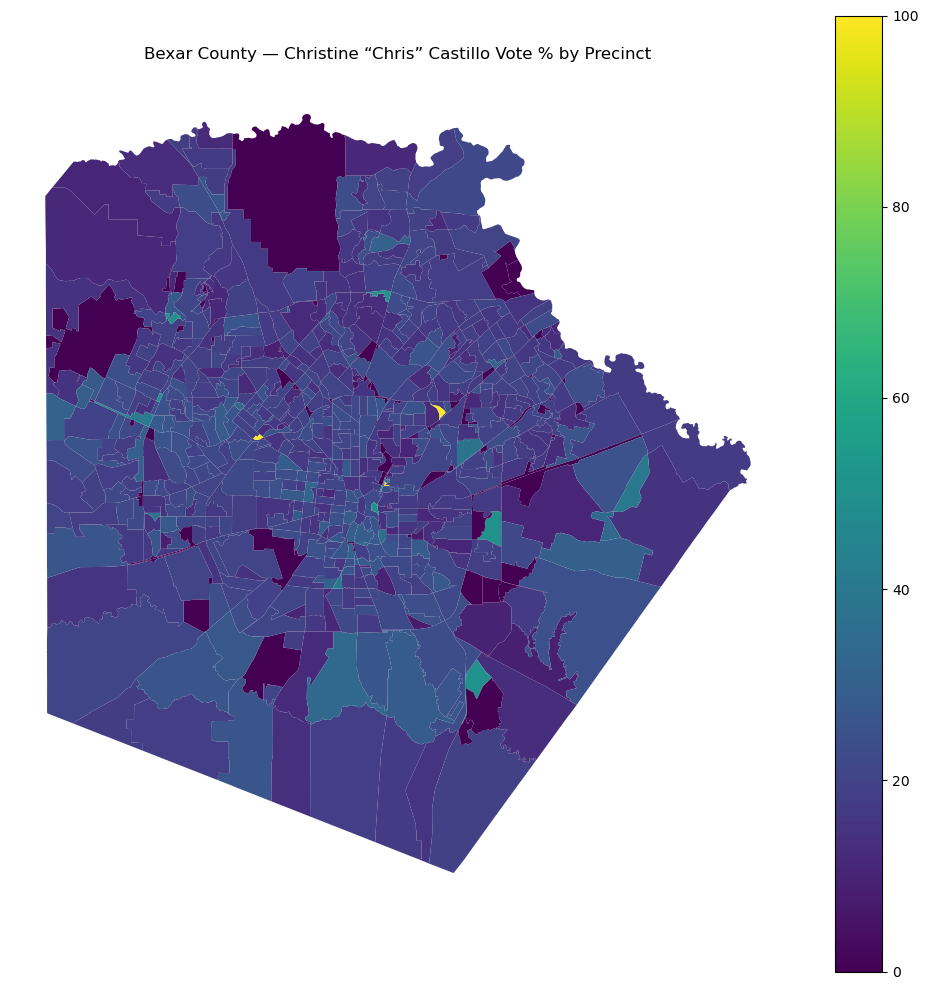

In [39]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 1) Load precinct polygons (you already did this earlier)
gdf = gpd.read_file("Bexar_County_Voter_Precincts.geojson")

# 2) Build a clean join key from the detected column
gdf["precinct"] = gdf["NAME"].astype(str).str.extract(r"(\d{4})", expand=False).str.strip()

# 3) Castillo % table (one row per precinct)
castillo_pct = (
    dc_long[dc_long["candidate"].str.contains("Castillo", case=False, na=False)]
      .loc[:, ["precinct", "vote_pct"]]
      .drop_duplicates(subset=["precinct"])
      .assign(precinct=lambda d: d["precinct"].astype(str).str.extract(r"(\d{4})", expand=False).str.strip())
)

# 4) Merge polygons + percent
gdfm = gdf.merge(castillo_pct, on="precinct", how="left")

print("Polygons:", len(gdfm), " | with Castillo %:", gdfm["vote_pct"].notna().sum())

# 5) Choropleth
ax = gdfm.plot(
    column="vote_pct",
    legend=True,
    figsize=(10,10),
    missing_kwds={"color":"lightgrey", "label":"No data"}
)
ax.set_axis_off()
ax.set_title("Bexar County — Christine “Chris” Castillo Vote % by Precinct", pad=12)
plt.tight_layout()
plt.show()

In [40]:
import numpy as np

# 1️⃣ Option A — fixed threshold (e.g., < 10% vote share)
threshold = 10
weak_precincts = gdfm[gdfm["vote_pct"] < threshold].copy()

print(f"Weak precincts (below {threshold}%): {len(weak_precincts)}")

Weak precincts (below 10%): 126


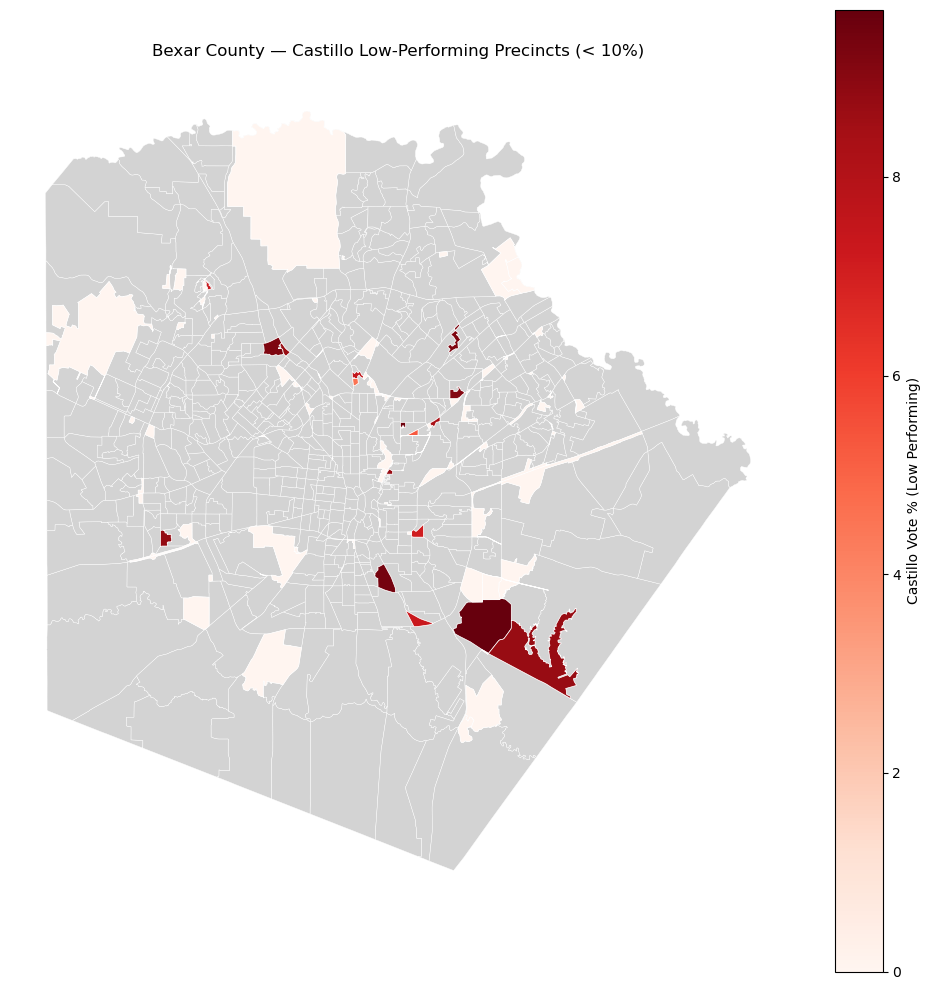

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

# plot full county in light grey
gdfm.plot(ax=ax, color="lightgrey", linewidth=0.3, edgecolor="white")

# overlay weak precincts in red shades
weak_precincts.plot(
    ax=ax,
    column="vote_pct",
    cmap="Reds",
    legend=True,
    legend_kwds={"label": "Castillo Vote % (Low Performing)"},
    linewidth=0.5,
    edgecolor="white"
)

ax.set_title(f"Bexar County — Castillo Low-Performing Precincts (< {threshold}%)", pad=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [42]:
import numpy as np

#  Option B — relative (below her median performance)
median_pct = gdfm["vote_pct"].median()
weak_precincts = gdfm[gdfm["vote_pct"] < median_pct].copy()

print(f"Weak precincts (below {threshold}%): {len(weak_precincts)}")

Weak precincts (below 10%): 386


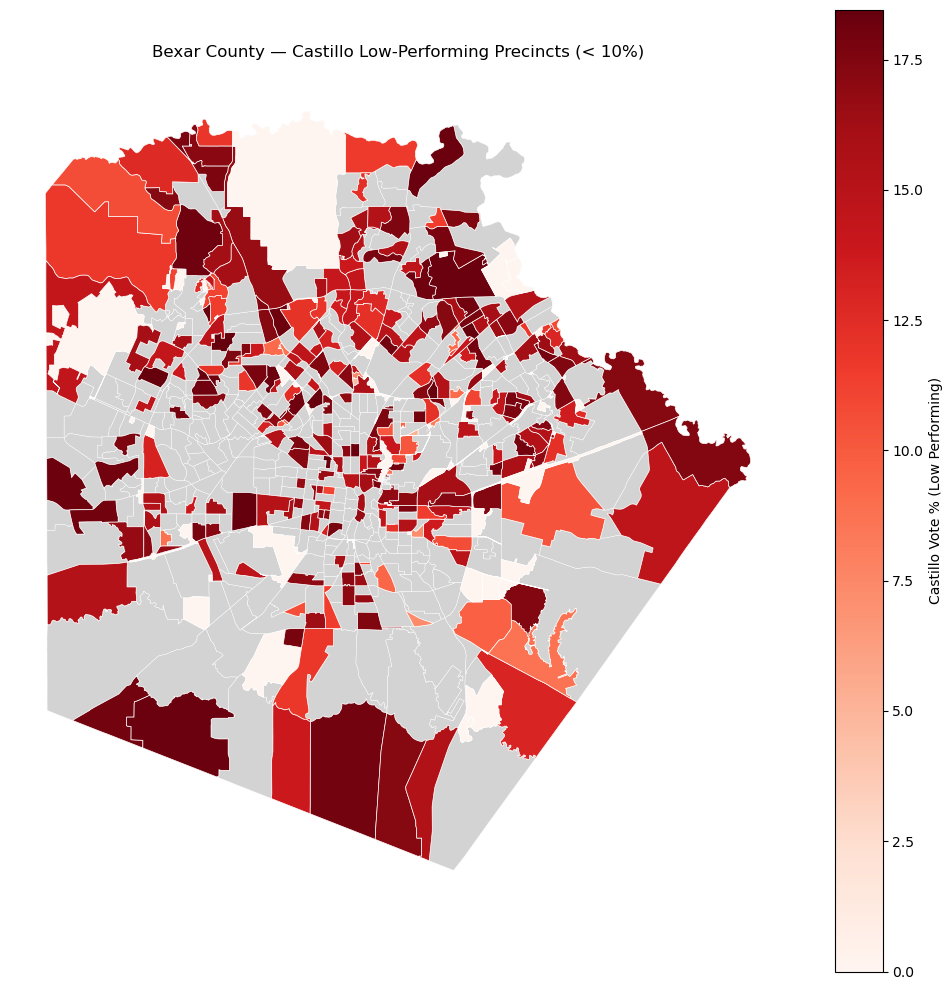

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))

# plot full county in light grey
gdfm.plot(ax=ax, color="lightgrey", linewidth=0.3, edgecolor="white")

# overlay weak precincts in red shades
weak_precincts.plot(
    ax=ax,
    column="vote_pct",
    cmap="Reds",
    legend=True,
    legend_kwds={"label": "Castillo Vote % (Low Performing)"},
    linewidth=0.5,
    edgecolor="white"
)

ax.set_title(f"Bexar County — Castillo Low-Performing Precincts (< {threshold}%)", pad=12)
ax.set_axis_off()
plt.tight_layout()
plt.show()

Total polygons with >=10 total votes: 636
Weak (>=10 votes & vote_pct < 10.0%): 18


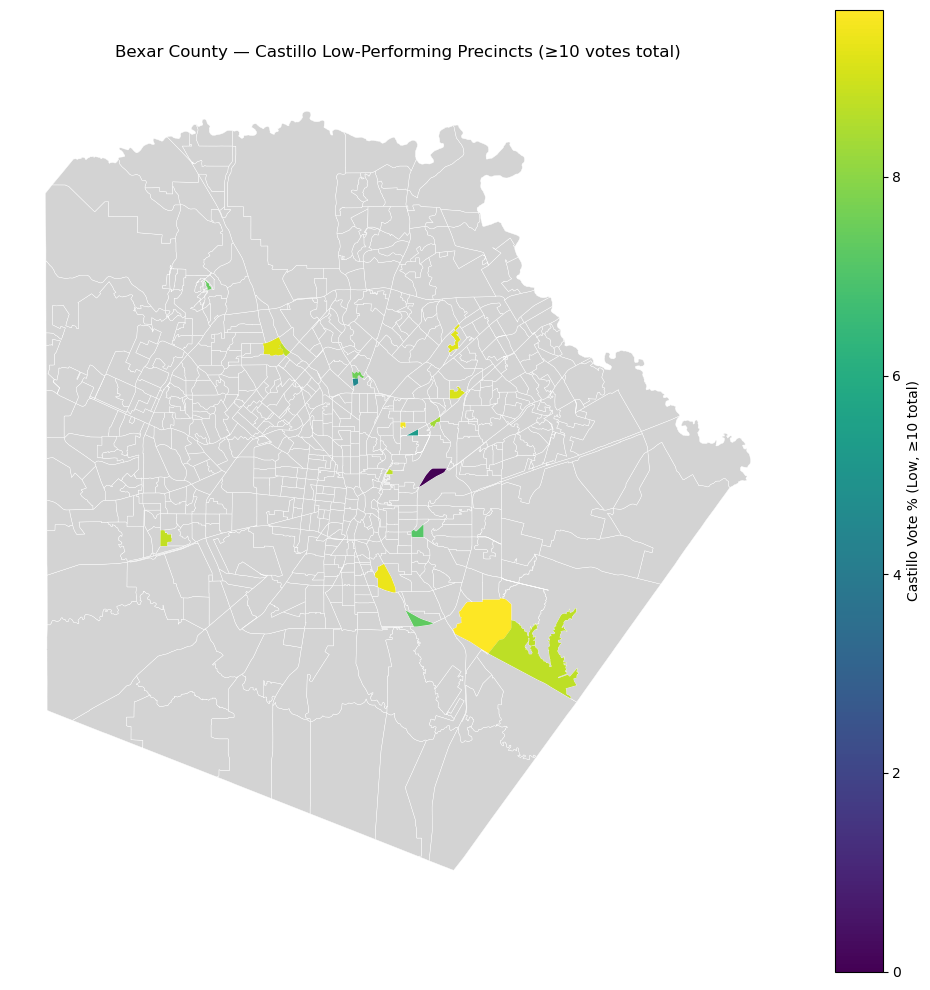

In [44]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- 0) Geo: make sure we have a clean precinct key on polygons ---
# (only needed once; keep if not already done)
gdf = gpd.read_file("Bexar_County_Voter_Precincts.geojson")
gdf["precinct"] = gdf["NAME"].astype(str).str.extract(r"(\d{4})", expand=False).str.strip()

# --- 1) Build Castillo % by precinct LIMITED to precincts with >=10 total votes ---
# over_10_total_df should already be Castillo-only rows with a precinct_total >= 10
# If it is built from 'castillo', it already has columns: precinct, vote_pct, precinct_total, etc.
castillo_pct_over10 = (
    over_10_total_df
        .loc[:, ["precinct", "vote_pct", "precinct_total"]]
        .drop_duplicates(subset=["precinct"])
        .assign(precinct=lambda d: d["precinct"].astype(str).str.extract(r"(\d{4})", expand=False).str.strip())
)

# --- 2) Merge into polygons (only those precincts will carry vote_pct) ---
gdf_over10 = gdf.merge(castillo_pct_over10, on="precinct", how="inner")
print("Total polygons with >=10 total votes:", len(gdf_over10))

# --- 3) Choose "low-performing" definition ---
# Option A: fixed threshold (e.g., < 10% for Castillo)
threshold = 10.0
weak_over10 = gdf_over10[gdf_over10["vote_pct"] < threshold].copy()

# Option B (alternative): below median among >=10 precincts
# med = gdf_over10["vote_pct"].median()
# weak_over10 = gdf_over10[gdf_over10["vote_pct"] < med].copy()

print(f"Weak (>=10 votes & vote_pct < {threshold}%):", len(weak_over10))

# --- 4) Plot: show only those low-performing (>=10) precincts over county base ---
fig, ax = plt.subplots(figsize=(10,10))
# base county outline (all precincts, light gray)
gdf.plot(ax=ax, color="lightgrey", linewidth=0.3, edgecolor="white")
# overlay weak precincts from the over_10 set
weak_over10.plot(
    ax=ax,
    column="vote_pct",
    legend=True,
    legend_kwds={"label": "Castillo Vote % (Low, ≥10 total)"},
)
ax.set_axis_off()
ax.set_title("Bexar County — Castillo Low-Performing Precincts (≥10 votes total)", pad=12)
plt.tight_layout()
plt.show()

In [45]:
weak_over10_sorted = weak_over10.sort_values("vote_pct", ascending=True)
print("Weak precincts (>=10 total votes & vote_pct < 10%):")
print(weak_over10_sorted[["precinct", "vote_pct", "precinct_total"]].to_string(index=False))

Weak precincts (>=10 total votes & vote_pct < 10%):
precinct  vote_pct  precinct_total
    4111      0.00            16.0
    2092      4.55            22.0
    4147      5.26            19.0
    4141      7.14            14.0
    1117      7.32            41.0
    3185      7.41            27.0
    3014      7.55            53.0
    4120      8.33            12.0
    4086      8.70            23.0
    4119      8.70            46.0
    3010      8.70            23.0
    1142      8.79            91.0
    4205      9.09            11.0
    4176      9.21            76.0
    3056      9.22           141.0
    1019      9.38            64.0
    4222      9.52            21.0
    4073      9.68            93.0
